# PyHDX basics

In [1]:
from pyhdx import PeptideMasterTable, read_dynamx
from pyhdx.plot import plot_peptides
import matplotlib.pyplot as plt
from pathlib import Path

We can use the ``read_dynamx`` function to read the file. This function returns a ``numpy`` structured array where each
entry corresponds to one peptide, in this example 567 peptides. 

In [2]:
fpath = Path() / '..' / '..' / 'tests' / 'test_data' / 'ecSecB_apo.csv'
data = read_dynamx(fpath)
len(data)

567

This array is loaded into the ``PeptideMasterTable`` class, which is the main data entry class. The parameter ``drop_first``
determines how many N-terminal residues are considered to be fully back-exchanged, and therefore is subtracted from the
total amount of exchangable D per peptide. The parameter ``ignore_prolines`` is controls whether the number of Prolines
residues in the peptide should be subtracted from the total amount of exchangable and should generally be set to ``True``.

The final number of exchangable residues is found in the 'ex_residues' field.

In [3]:
master_table = PeptideMasterTable(data, drop_first=1, ignore_prolines=True)
master_table.data['ex_residues'][:50]

array([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 13., 13., 13., 13., 13., 13., 13., 13., 13., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 20., 20., 20., 20., 20.])

This master table allows us to control how the deuterium uptake content is determined. The method ``set_control`` can be
used to choose which set of peptides is used as the fully deuterated (FD) control. This adds a new field called 'uptake'
which is the normalized (to 100%) deuterium uptake of each peptide, with respect to the total amount of exchanging residues.

In [4]:
master_table.set_control(('Full deuteration control', 0.167))
master_table.data['uptake'][:50]

array([ 0.      ,  0.      ,  5.0734  ,  2.486444,  2.857141,  3.145738,
        3.785886,  4.08295 ,  4.790625,  0.      ,  0.      ,  3.642506,
        1.651437,  1.860919,  2.107151,  2.698036,  2.874801,  3.449561,
        0.      ,  0.      ,  5.264543,  1.839924,  2.508343,  2.969332,
        3.399092,  3.485568,  4.318144,  0.      ,  0.      ,  6.3179  ,
        2.532099,  3.306167,  3.996718,  4.38941 ,  4.379495,  5.283969,
        0.      ,  0.      ,  6.812215,  3.11985 ,  3.874881,  4.342807,
        4.854057,  4.835639,  5.780219,  0.      ,  0.      , 10.8151  ,
        5.432395,  6.1318  ])

Next we'll split the data and group them by their different states. This returns a dictionary where the values are
all peptides for a given state. The peptides for each state are grouped by their exposure time, forming a ``KineticSeries`` 
object

In [5]:
states = master_table.groupby_state()
for key, value in states.items():
    print(key, value)

Full deuteration control <pyhdx.models.KineticsSeries object at 0x000002769DC6D8E0>
SecB WT apo <pyhdx.models.KineticsSeries object at 0x000002769DC6DCD0>


In [6]:
series = states['SecB WT apo']
type(series), len(series), series.timepoints

(pyhdx.models.KineticsSeries,
 7,
 array([  0.      ,   0.167   ,   0.5     ,   1.      ,   5.      ,
         10.      , 100.000008]))

Iterating over a ``KineticSeries`` object returns a set of ``PeptideMeasurements`` each with their own attributes describing
the topology of the coverage. When creating the object, peptides which are not present in all timepoints are removed, such
that all timepoints and ``PeptideMeasurements`` have identical coverage.

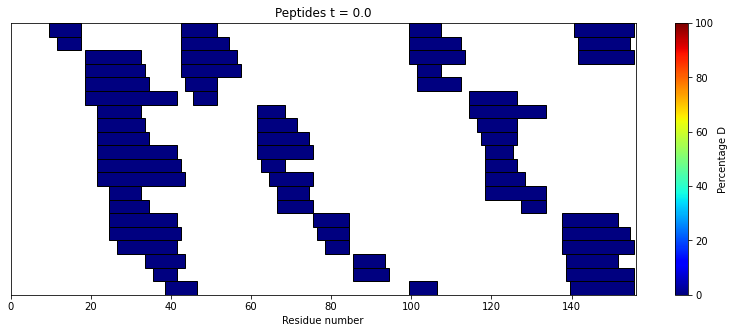

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))
i = 0
plot_peptides(series[i], ax, 20, cbar=True)
t = ax.set_title(f'Peptides t = {series.timepoints[i]}')
l = ax.set_xlabel('Residue number')

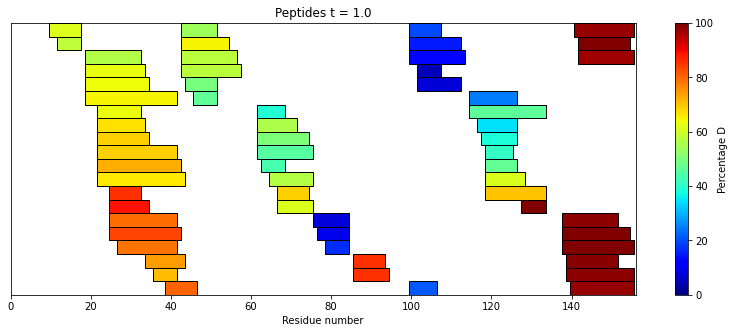

In [10]:
fig, ax = plt.subplots(figsize=(14, 5))
i = 3
plot_peptides(series[i], ax, 20, cbar=True)
t = ax.set_title(f'Peptides t = {series.timepoints[i]}')
l = ax.set_xlabel('Residue number')